# Convolutional Neural Networks

## Setup

run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [3]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load the CIFAR-10 dataset

The utility function `preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

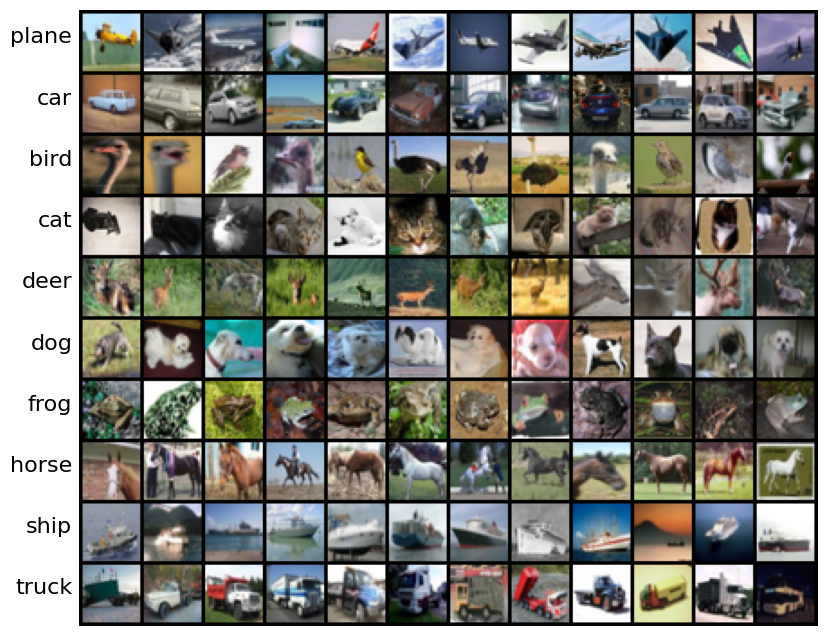

Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [5]:
from convolutional_networks import preprocess_cifar10

data_dict = preprocess_cifar10(cuda=True, dtype=torch.float64, flatten=False)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

## Convolutional networks

### Convolutional layer

package each new neural network operator in a class that defines a `forward` and `backward` function.

#### Convolutional layer: forward

The core of a convolutional network is the convolution operation. 

#### Aside: Image processing via convolutions

As fun way to both check the implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34544\2557158160.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten = imread(kitten_url)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34544\2557158160.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  puppy = imread(puppy_url)


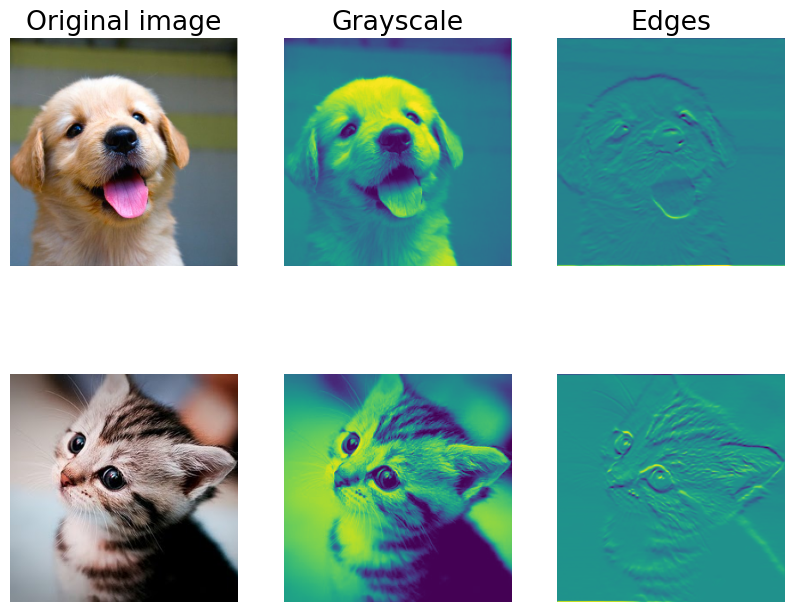

In [7]:
from imageio import imread
from PIL import Image
from torchvision.transforms import ToTensor
from convolutional_networks import Conv

kitten_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/kitten.jpg'
puppy_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/puppy.jpg'

kitten = imread(kitten_url)
puppy = imread(puppy_url)
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = ToTensor()(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = ToTensor()(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = torch.stack([resized_puppy, resized_kitten])

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=x.dtype)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = Conv.forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
  """ Tiny helper to show images as uint8 and remove axis labels """
  if normalize:
    img_max, img_min = img.max(), img.min()
    img = 255.0 * (img - img_min) / (img_max - img_min)
  plt.imshow(img)
  plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

#### Convolutional layer: backward

In [8]:
from convolutional_networks import Conv,compute_numeric_gradient,rel_error

x = torch.randn(4, 3, 5, 5, dtype=torch.float64, device='cuda')
w = torch.randn(2, 3, 3, 3, dtype=torch.float64, device='cuda')
b = torch.randn(2, dtype=torch.float64, device='cuda')
dout = torch.randn(4, 2, 5, 5, dtype=torch.float64, device='cuda')
conv_param = {'stride': 1, 'pad': 1}

dx_num = compute_numeric_gradient(lambda x: Conv.forward(x, w, b, conv_param)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Conv.forward(x, w, b, conv_param)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Conv.forward(x, w, b, conv_param)[0], b, dout)

out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)

print('Testing Conv.backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing Conv.backward function
dx error:  2.496440948929281e-09
dw error:  9.222783256472505e-10
db error:  1.201214303148521e-09


### Max-pooling

#### Max-pooling: forward

#### Max-pooling: backward

Check the implementation of the max pooling backward pass with numeric gradient checking by running the following. 

In [9]:
from convolutional_networks import MaxPool

x = torch.randn(3, 2, 8, 8, dtype=torch.float64, device='cuda')
dout = torch.randn(3, 2, 4, 4, dtype=torch.float64, device='cuda')
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num =compute_numeric_gradient(lambda x: MaxPool.forward(x, pool_param)[0], x, dout)

out, cache = MaxPool.forward(x, pool_param)
dx = MaxPool.backward(dout, cache)

print('Testing MaxPool.backward function:')
print('dx error: ', rel_error(dx, dx_num))

Testing MaxPool.backward function:
dx error:  8.182894203997199e-10


### Fast layers

Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers. Those can be found at the bottom of `convolutional_networks.py`

The fast convolution implementation depends on `torch.nn`

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that we implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

```python
class FastConv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']
    layer = torch.nn.Conv2d(C, F, (HH, WW), stride=stride, padding=pad)
    layer.weight = torch.nn.Parameter(w)
    layer.bias = torch.nn.Parameter(b)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, w, b, conv_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, _, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
      dw = layer.weight.grad.detach()
      db = layer.bias.grad.detach()
      layer.weight.grad = layer.bias.grad = None
    except RuntimeError:
      dx, dw, db = torch.zeros_like(tx), torch.zeros_like(layer.weight), torch.zeros_like(layer.bias)
    return dx, dw, db


class FastMaxPool(object):

  @staticmethod
  def forward(x, pool_param):
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
    stride = pool_param['stride']
    layer = torch.nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=stride)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, pool_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
    except RuntimeError:
      dx = torch.zeros_like(tx)
    return dx
```

## Convolutional "sandwich" layers

Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. Below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. We've included them at the bottom of `covolutional_networks.py` Run the cells below to sanity check they're working.

```python
class Conv_ReLU(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    """
    A convenience layer that performs a convolution followed by a ReLU.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    out, relu_cache = ReLU.forward(a)
    cache = (conv_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db


class Conv_ReLU_Pool(object):

  @staticmethod
  def forward(x, w, b, conv_param, pool_param):
    """
    A convenience layer that performs a convolution, a ReLU, and a pool.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer
    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    s, relu_cache = ReLU.forward(a)
    out, pool_cache = FastMaxPool.forward(s, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = FastMaxPool.backward(dout, pool_cache)
    da = ReLU.backward(ds, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db
```

## Three-layer convolutional network

put all the necessary layers together into a simple convolutional network

the `ThreeLayerConvNet` class in the file `convolutional_network.py`

### Gradient check

use numeric gradient checking 

In [10]:
from convolutional_networks import ThreeLayerConvNet

num_inputs = 2
input_dims = (3, 16, 16)
reg = 0.0
num_classes = 10

X = torch.randn(num_inputs, *input_dims, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device='cuda')

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dims=input_dims, hidden_dim=7,
                          weight_scale=5e-2, dtype=torch.float64, device='cuda')
loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = compute_numeric_gradient(f, model.params[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.241071e-08
W2 max relative error: 4.497831e-08
W3 max relative error: 1.605856e-08
b1 max relative error: 3.884400e-08
b2 max relative error: 5.297032e-09
b3 max relative error: 2.556433e-09


## Overfit small data

A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [11]:
from convolutional_networks import ThreeLayerConvNet,adam,Solver

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-3, dtype=torch.float32, device='cuda')

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=1,
                device='cuda')
solver.train()

(Time 0.18 sec; Iteration 1 / 60) loss: 2.302585
(Epoch 0 / 30) train acc: 0.160000; val_acc: 0.101400
(Time 0.36 sec; Iteration 2 / 60) loss: 2.300700
(Epoch 1 / 30) train acc: 0.160000; val_acc: 0.101400
(Time 0.40 sec; Iteration 3 / 60) loss: 2.285590
(Time 0.41 sec; Iteration 4 / 60) loss: 2.247391
(Epoch 2 / 30) train acc: 0.170000; val_acc: 0.103000
(Time 0.46 sec; Iteration 5 / 60) loss: 2.292857
(Time 0.46 sec; Iteration 6 / 60) loss: 2.155502
(Epoch 3 / 30) train acc: 0.160000; val_acc: 0.101400
(Time 0.52 sec; Iteration 7 / 60) loss: 2.118623
(Time 0.52 sec; Iteration 8 / 60) loss: 2.147465
(Epoch 4 / 30) train acc: 0.170000; val_acc: 0.102100
(Time 0.57 sec; Iteration 9 / 60) loss: 2.067545
(Time 0.58 sec; Iteration 10 / 60) loss: 2.014383
(Epoch 5 / 30) train acc: 0.270000; val_acc: 0.140000
(Time 0.63 sec; Iteration 11 / 60) loss: 2.144225
(Time 0.63 sec; Iteration 12 / 60) loss: 1.981341
(Epoch 6 / 30) train acc: 0.310000; val_acc: 0.150600
(Time 0.69 sec; Iteration 13 / 

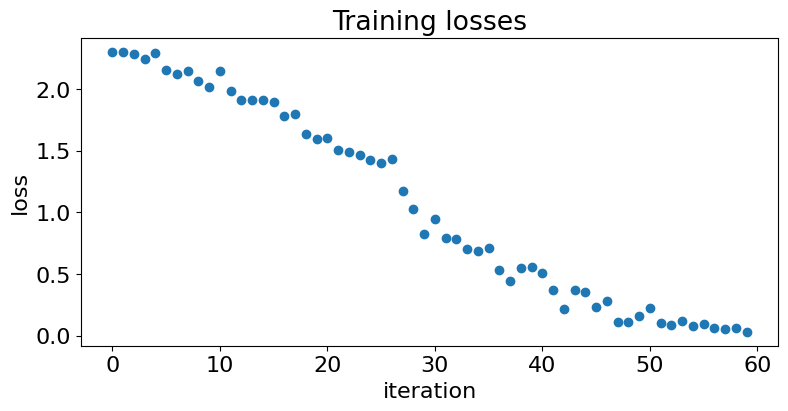

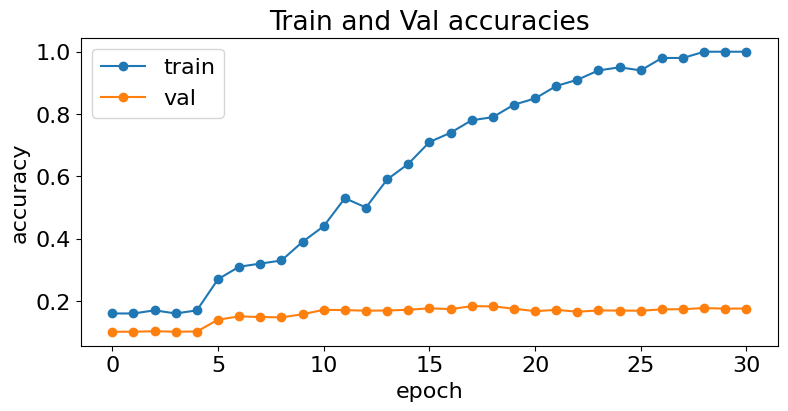

In [12]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Train the net

train the three-layer convolutional network for one epoch

In [14]:
from convolutional_networks import ThreeLayerConvNet

model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, dtype=torch.float, device='cuda')

solver = Solver(model, data_dict,
                num_epochs=1, batch_size=64,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=50, device='cuda')
solver.train()

(Time 0.03 sec; Iteration 1 / 625) loss: 2.306694
(Epoch 0 / 1) train acc: 0.104000; val_acc: 0.101400
(Time 0.37 sec; Iteration 51 / 625) loss: 1.861917
(Time 0.60 sec; Iteration 101 / 625) loss: 2.088144
(Time 0.82 sec; Iteration 151 / 625) loss: 1.844214
(Time 1.05 sec; Iteration 201 / 625) loss: 1.850080
(Time 1.28 sec; Iteration 251 / 625) loss: 1.879103
(Time 1.50 sec; Iteration 301 / 625) loss: 1.658086
(Time 1.73 sec; Iteration 351 / 625) loss: 1.923604
(Time 1.95 sec; Iteration 401 / 625) loss: 1.588561
(Time 2.18 sec; Iteration 451 / 625) loss: 1.425021
(Time 2.40 sec; Iteration 501 / 625) loss: 1.747891
(Time 2.62 sec; Iteration 551 / 625) loss: 1.555911
(Time 2.84 sec; Iteration 601 / 625) loss: 1.492276
(Epoch 1 / 1) train acc: 0.527000; val_acc: 0.502800


## Visualize Filters

visualize the first-layer convolutional filters from the trained network 

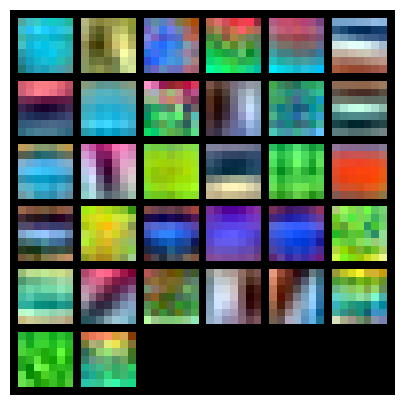

In [15]:
from torchvision.utils import make_grid

nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

## Deep convolutional network

implement a deep convolutional network with an arbitrary number of conv layers in VGGNet style.

the `DeepConvNet` class in the file `convlutional_networks.py`

### Gradient check

use numeric gradient checking

In [17]:
from convolutional_networks import DeepConvNet

N = 50
num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
X = torch.randn(N, *input_dims, dtype=torch.float64, device='cuda')
y = torch.randint(10, size=(N,), dtype=torch.int64, device='cuda')

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 2],
                      reg=reg,
                      weight_scale=5e-2, dtype=torch.float64, device='cuda')

  loss, grads = model.loss(X, y)
  # The relative errors should be up to the order of e-6
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s max relative error: %e' % (name,rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
W0 max relative error: 6.781907e-07
W1 max relative error: 7.554636e-07
W2 max relative error: 1.281488e-06
W3 max relative error: 6.184857e-07
b0 max relative error: 1.255228e-06
b1 max relative error: 3.659811e-07
b2 max relative error: 1.877774e-07
b3 max relative error: 2.315082e-08

Running check with reg =  3.14
W0 max relative error: 8.245301e-09
W1 max relative error: 8.294972e-09
W2 max relative error: 9.832691e-09
W3 max relative error: 6.443369e-09
b0 max relative error: 3.032008e-06
b1 max relative error: 6.066087e-07
b2 max relative error: 2.306334e-07
b3 max relative error: 5.629463e-08


### Overfit small data

As another sanity check, make sure you can overfit a small dataset of 50 images. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 30 epochs.

(Time 0.05 sec; Iteration 1 / 150) loss: 2.314150
(Epoch 0 / 30) train acc: 0.100000; val_acc: 0.084700
(Epoch 1 / 30) train acc: 0.160000; val_acc: 0.102000
(Epoch 2 / 30) train acc: 0.180000; val_acc: 0.102600
(Time 0.57 sec; Iteration 11 / 150) loss: 2.248112
(Epoch 3 / 30) train acc: 0.220000; val_acc: 0.105000
(Epoch 4 / 30) train acc: 0.360000; val_acc: 0.119400
(Time 0.91 sec; Iteration 21 / 150) loss: 2.162122
(Epoch 5 / 30) train acc: 0.380000; val_acc: 0.124200
(Epoch 6 / 30) train acc: 0.300000; val_acc: 0.106000
(Time 1.16 sec; Iteration 31 / 150) loss: 2.018715
(Epoch 7 / 30) train acc: 0.320000; val_acc: 0.106900
(Epoch 8 / 30) train acc: 0.460000; val_acc: 0.135700
(Time 1.43 sec; Iteration 41 / 150) loss: 1.450041
(Epoch 9 / 30) train acc: 0.600000; val_acc: 0.156300
(Epoch 10 / 30) train acc: 0.520000; val_acc: 0.157400
(Time 1.68 sec; Iteration 51 / 150) loss: 1.803460
(Epoch 11 / 30) train acc: 0.580000; val_acc: 0.192600
(Epoch 12 / 30) train acc: 0.680000; val_acc:

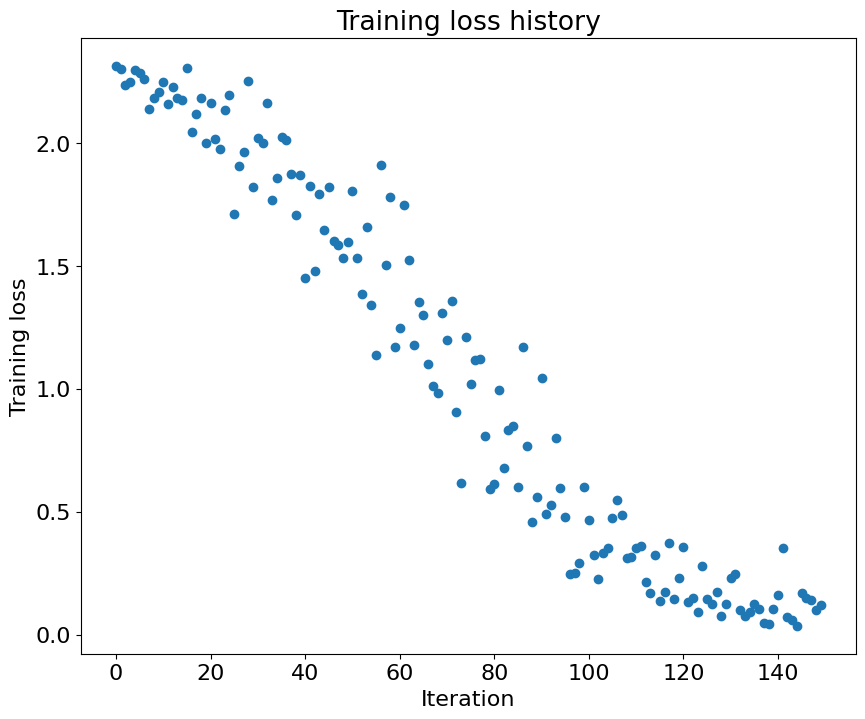

1.0


In [18]:
from convolutional_networks import DeepConvNet, find_overfit_parameters

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = small_data['X_train'].shape[1:]

weight_scale, learning_rate = find_overfit_parameters()

model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

val_acc = solver.check_accuracy(solver.X_train, solver.y_train, num_samples=solver.num_train_samples)
print(val_acc)

In [19]:
import os
path = os.path.join('../models', 'overfit_deepconvnet.pth')
solver.model.save(path)

# Create a new instance
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )


# Load model
solver.model.load(path, dtype=torch.float32, device='cuda')

# Evaluate on validation set
accuracy = solver.check_accuracy(small_data['X_train'], small_data['y_train'])
print(f"Saved model's accuracy on training is {accuracy}")


Saved in ../models\overfit_deepconvnet.pth
load checkpoint file: ../models\overfit_deepconvnet.pth
Saved model's accuracy on training is 1.0


## Kaiming initialization

However, manually tuning the weight scale and for weight initialization is inefficient when it comes to training deep neural networks; practically, as the weight matrix is larger, the weight scale should be small.
Below we will implement [Kaiming initialization](http://arxiv-web3.library.cornell.edu/abs/1502.01852). For more details, refer to [cs231n note](http://cs231n.github.io/neural-networks-2/#init) and [PyTorch documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

### Convolutional nets with Kaiming initialization

Modify the implementation to add Kaiming initialization.

Concretely, when the `weight_scale` is set to `'kaiming'` in the constructor, you should initialize weights of convolutional and linear layers using `kaiming_initializer`. 

Here we train a 31-layer network with four different weight initialization schemes. Among them, only the Kaiming initialization method should achieve a non-random accuracy after one epoch of training.

We may see `nan` loss when `weight_scale` is large, this shows a catastrophe of inappropriate weight initialization.

In [20]:
from convolutional_networks import DeepConvNet,sgd_momentum

# Try training a deep convolutional net with different weight initialization methods
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

weight_scales = ['kaiming', 1e-1, 1e-2, 1e-3]

solvers = []
for weight_scale in weight_scales:
  print('Solver with weight scale: ', weight_scale)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=([8] * 10) + ([32] * 10) + ([128] * 10),
                      max_pools=[9, 19],
                      weight_scale=weight_scale,
                      reg=1e-5, 
                      dtype=torch.float32,
                      device='cuda'
                      )

  solver = Solver(model, small_data,
                  num_epochs=1, batch_size=128,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': 2e-3,
                  },
                  print_every=20, device='cuda')
  solver.train()
  solvers.append(solver)

Solver with weight scale:  kaiming
(Time 0.22 sec; Iteration 1 / 78) loss: 2.302708
(Epoch 0 / 1) train acc: 0.102000; val_acc: 0.101400
(Time 1.75 sec; Iteration 21 / 78) loss: 2.302924
(Time 2.32 sec; Iteration 41 / 78) loss: 2.302133
(Time 2.88 sec; Iteration 61 / 78) loss: 2.302761
(Epoch 1 / 1) train acc: 0.094000; val_acc: 0.101600
Solver with weight scale:  0.1
(Time 0.03 sec; Iteration 1 / 78) loss: 39.729919
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.101400
(Time 1.70 sec; Iteration 21 / 78) loss: nan
(Time 2.44 sec; Iteration 41 / 78) loss: nan
(Time 3.09 sec; Iteration 61 / 78) loss: nan
(Epoch 1 / 1) train acc: 0.095000; val_acc: 0.101400
Solver with weight scale:  0.01
(Time 0.03 sec; Iteration 1 / 78) loss: 2.304121
(Epoch 0 / 1) train acc: 0.088000; val_acc: 0.102200
(Time 1.55 sec; Iteration 21 / 78) loss: 2.303957
(Time 2.13 sec; Iteration 41 / 78) loss: 2.304080
(Time 2.75 sec; Iteration 61 / 78) loss: 2.304240
(Epoch 1 / 1) train acc: 0.105000; val_acc: 0.095200
S

In [21]:
from convolutional_networks import DeepConvNet

# Try training a deep convolutional net with different weight initialization methods
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

weight_scales = ['kaiming', 1e-1, 1e-2, 1e-3]

solvers = []
for weight_scale in weight_scales:
  print('Solver with weight scale: ', weight_scale)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=([8] * 10) + ([32] * 10) + ([128] * 10),
                      max_pools=[9, 19],
                      weight_scale=weight_scale,
                      reg=1e-5, 
                      dtype=torch.float32,
                      device='cuda'
                      )

  solver = Solver(model, small_data,
                  num_epochs=1, batch_size=128,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': 2e-3,
                  },
                  print_every=20, device='cuda')
  solver.train()
  solvers.append(solver)

Solver with weight scale:  kaiming
(Time 0.14 sec; Iteration 1 / 78) loss: 2.302711
(Epoch 0 / 1) train acc: 0.100000; val_acc: 0.097700
(Time 1.78 sec; Iteration 21 / 78) loss: 2.302702
(Time 2.37 sec; Iteration 41 / 78) loss: 2.303164
(Time 2.97 sec; Iteration 61 / 78) loss: 2.302939
(Epoch 1 / 1) train acc: 0.104000; val_acc: 0.099700
Solver with weight scale:  0.1
(Time 0.03 sec; Iteration 1 / 78) loss: 20.807367
(Epoch 0 / 1) train acc: 0.092000; val_acc: 0.102500
(Time 1.55 sec; Iteration 21 / 78) loss: nan
(Time 2.12 sec; Iteration 41 / 78) loss: nan
(Time 2.69 sec; Iteration 61 / 78) loss: nan
(Epoch 1 / 1) train acc: 0.091000; val_acc: 0.101400
Solver with weight scale:  0.01
(Time 0.03 sec; Iteration 1 / 78) loss: 2.304120
(Epoch 0 / 1) train acc: 0.082000; val_acc: 0.101400
(Time 1.55 sec; Iteration 21 / 78) loss: 2.304393
(Time 2.14 sec; Iteration 41 / 78) loss: 2.304410
(Time 2.73 sec; Iteration 61 / 78) loss: 2.303947
(Epoch 1 / 1) train acc: 0.114000; val_acc: 0.100300
S

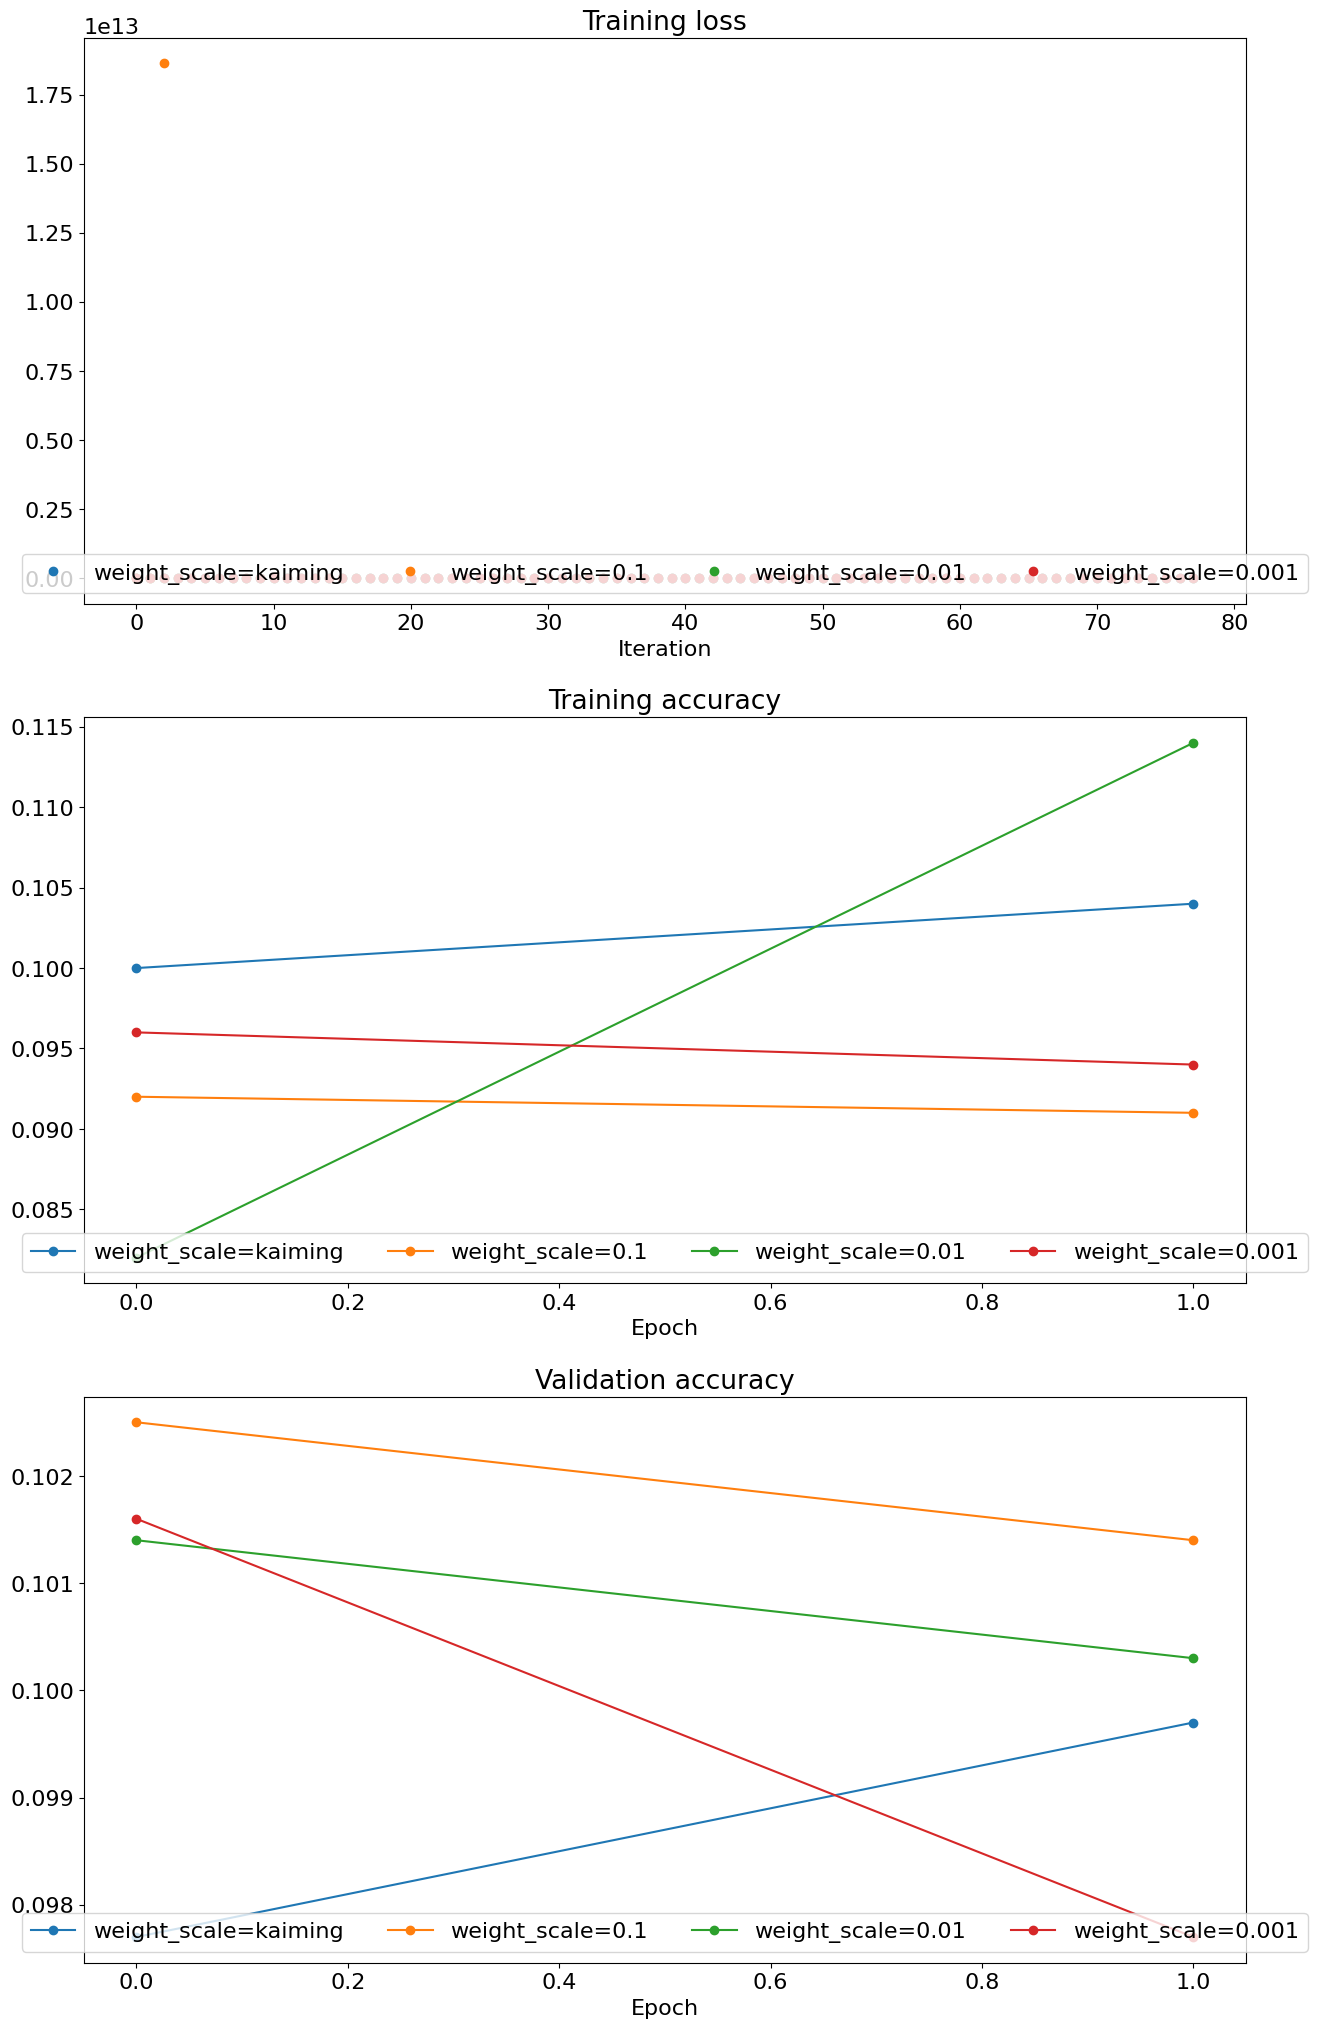

In [22]:
def plot_training_history_init(title, xlabel, solvers, labels, plot_fn, marker='-o'):
  plt.title(title)
  plt.xlabel(xlabel)
  for solver, label in zip(solvers, labels):    
    data = plot_fn(solver)
    label = 'weight_scale=' + str(label)
    plt.plot(data, marker, label=label)
  plt.legend(loc='lower center', ncol=len(solvers))

plt.subplot(3, 1, 1)
plot_training_history_init('Training loss','Iteration', solvers, weight_scales,
                            lambda x: x.loss_history, marker='o')
plt.subplot(3, 1, 2)
plot_training_history_init('Training accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.train_acc_history)
plt.subplot(3, 1, 3)
plot_training_history_init('Validation accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.val_acc_history)
plt.gcf().set_size_inches(15, 25)
plt.show()

## Train a good model!

Train the best convolutional model  on CIFAR-10, storing the best model in the `best_model` variable. 

`create_convolutional_solver_instance` while making sure to use the initialize the model with the input `dtype` and `device`, as well as initializing the solver on the input `device`. 

In [23]:
from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

solver = create_convolutional_solver_instance(data_dict, torch.float32, "cuda")

solver.train(time_limit=60)

torch.backends.cudnn.benchmark = False

(Time 0.29 sec; Iteration 1 / 62400) loss: 2.302596
(Epoch 0 / 200) train acc: 0.093000; val_acc: 0.099700
(Time 0.51 sec; Iteration 21 / 62400) loss: 2.038246
(Time 0.62 sec; Iteration 41 / 62400) loss: 2.105336
(Time 0.87 sec; Iteration 61 / 62400) loss: 2.031893
(Time 0.99 sec; Iteration 81 / 62400) loss: 2.049926
(Time 1.12 sec; Iteration 101 / 62400) loss: 1.859559
(Time 1.25 sec; Iteration 121 / 62400) loss: 1.859162
(Time 1.37 sec; Iteration 141 / 62400) loss: 1.785373
(Time 1.49 sec; Iteration 161 / 62400) loss: 1.825454
(Time 1.61 sec; Iteration 181 / 62400) loss: 1.577620
(Time 1.73 sec; Iteration 201 / 62400) loss: 1.677467
(Time 1.85 sec; Iteration 221 / 62400) loss: 1.516149
(Time 1.97 sec; Iteration 241 / 62400) loss: 1.738499
(Time 2.09 sec; Iteration 261 / 62400) loss: 1.455746
(Time 2.23 sec; Iteration 281 / 62400) loss: 1.445814
(Time 2.35 sec; Iteration 301 / 62400) loss: 1.668061
(Epoch 1 / 200) train acc: 0.448000; val_acc: 0.444500
(Time 2.58 sec; Iteration 321 / 

## Test the model!

Run the best model on the validation and test sets. 

In [24]:
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Validation set accuracy:  0.7092999815940857
Test set accuracy:  0.7032999992370605


In [25]:
path = os.path.join('../models', 'one_minute_deepconvnet.pth')
solver.model.save(path)

# Create a new instance
from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

solver = create_convolutional_solver_instance(data_dict, torch.float32, "cuda")

# Load model
solver.model.load(path, dtype=torch.float32, device='cuda')

# Evaluate on validation set
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Saved in ../models\one_minute_deepconvnet.pth
load checkpoint file: ../models\one_minute_deepconvnet.pth
Validation set accuracy:  0.7092999815940857
Test set accuracy:  0.7032999992370605


## Batch Normalization

One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. 
One idea along these lines is batch normalization which was proposed by [1] in 2015.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

### Batch normalization: forward

the function `BatchNorm.forward`

We can sanity-check the test-time forward pass of batch normalization by running the following. First we run the training-time forward pass many times to "warm up" the running averages. If we then run a test-time forward pass, the output should have approximately zero mean and unit variance.

In [26]:
from convolutional_networks import BatchNorm

def print_mean_std(x,dim=0):
  means = ['%.3f' % xx for xx in x.mean(dim=dim).tolist()]
  stds = ['%.3f' % xx for xx in x.std(dim=dim).tolist()]
  print('  means: ', means)
  print('  stds:  ', stds)
  print()


N, D1, D2, D3 = 200, 50, 60, 3
W1 = torch.randn(D1, D2, dtype=torch.float64, device='cuda')
W2 = torch.randn(D2, D3, dtype=torch.float64, device='cuda')

bn_param = {'mode': 'train'}
gamma = torch.ones(D3, dtype=torch.float64, device='cuda')
beta = torch.zeros(D3, dtype=torch.float64, device='cuda')

for t in range(500):
  X = torch.randn(N, D1, dtype=torch.float64, device='cuda')
  a = X.matmul(W1).clamp(min=0.).matmul(W2)
  BatchNorm.forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = torch.randn(N, D1, dtype=torch.float64, device='cuda')
a = X.matmul(W1).clamp(min=0.).matmul(W2)
a_norm, _ = BatchNorm.forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,dim=0)

After batch normalization (test-time):
  means:  ['0.084', '-0.011', '-0.027']
  stds:   ['0.986', '1.030', '0.992']



### Batch normalization: backward

the backward pass for batch normalization in the function `BatchNorm.backward`.

run the following to numerically check the backward pass.

In [27]:
from convolutional_networks import BatchNorm

N, D = 4, 5
x = 5 * torch.randn(N, D, dtype=torch.float64, device='cuda') + 12
gamma = torch.randn(D, dtype=torch.float64, device='cuda')
beta = torch.randn(D, dtype=torch.float64, device='cuda')
dout = torch.randn(N, D, dtype=torch.float64, device='cuda')

bn_param = {'mode': 'train'}
fx = lambda x: BatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: BatchNorm.forward(x, a, beta, bn_param)[0]
fb = lambda b: BatchNorm.forward(x, gamma, b, bn_param)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
da_num = compute_numeric_gradient(fg, gamma.clone(), dout)
db_num = compute_numeric_gradient(fb, beta.clone(), dout)

_, cache = BatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = BatchNorm.backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  9.95141540278591e-09
dgamma error:  2.2509138758118242e-10
dbeta error:  2.9193362391242196e-10


## Batch Normalization: alternative backward

In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too!  

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/batchnorm_graph.png" width=691 height=202>

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hart part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at 
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$, 
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$. 

the simplified batch normalization backward pass in the function `BatchNorm.backward_alt` 

## Spatial Batch Normalization

As proposed in the original paper, batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

### Spatial batch normalization: forward

the forward pass for spatial batch normalization in the function `SpatialBatchNorm.forward`

Similar to the vanilla batch normalization implementation, run the following to sanity-check the test-time forward pass of spatial batch normalization.

In [28]:
from convolutional_networks import SpatialBatchNorm

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = torch.ones(C, dtype=torch.float64, device='cuda')
beta = torch.zeros(C, dtype=torch.float64, device='cuda')
for t in range(50):
  x = 2.3 * torch.randn(N, C, H, W, dtype=torch.float64, device='cuda') + 13
  SpatialBatchNorm.forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * torch.randn(N, C, H, W, dtype=torch.float64, device='cuda') + 13
a_norm, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(dim=(0, 2, 3)))
print('  stds: ', a_norm.std(dim=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  tensor([ 0.0431, -0.0097,  0.0178,  0.0968], device='cuda:0',
       dtype=torch.float64)
  stds:  tensor([1.0326, 0.9927, 0.9821, 0.9877], device='cuda:0', dtype=torch.float64)


### Spatial batch normalization: backward
the backward pass for spatial batch normalization in the function `SpatialBatchNorm.backward`.

In [29]:
N, C, H, W = 2, 3, 4, 5
x = 5 * torch.randn(N, C, H, W, dtype=torch.float64, device='cuda') + 12
gamma = torch.randn(C, dtype=torch.float64, device='cuda')
beta = torch.randn(C, dtype=torch.float64, device='cuda')
dout = torch.randn(N, C, H, W, dtype=torch.float64, device='cuda')

bn_param = {'mode': 'train'}
fx = lambda x: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fb = lambda b: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
da_num = compute_numeric_gradient(fg, gamma, dout)
db_num = compute_numeric_gradient(fb, beta, dout)

_, cache = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = SpatialBatchNorm.backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ',rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.7896870209908872e-08
dgamma error:  6.28528550699392e-10
dbeta error:  5.403292416605578e-10


## "Sandwich" layers with batch normalization

Again, below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. We include the functions in `convolutional_networks.py` but you can see them here for your convenience. 

```python
class Linear_BatchNorm_ReLU(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that performs an linear transform, batch normalization,
    and ReLU.
    Inputs:
    - x: Array of shape (N, D1); input to the linear layer
    - w, b: Arrays of shape (D2, D2) and (D2,) giving the weight and bias for
      the linear transform.
    - gamma, beta: Arrays of shape (D2,) and (D2,) giving scale and shift
      parameters for batch normalization.
    - bn_param: Dictionary of parameters for batch normalization.
    Returns:
    - out: Output from ReLU, of shape (N, D2)
    - cache: Object to give to the backward pass.
    """
    a, fc_cache = Linear.forward(x, w, b)
    a_bn, bn_cache = BatchNorm.forward(a, gamma, beta, bn_param)
    out, relu_cache = ReLU.forward(a_bn)
    cache = (fc_cache, bn_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-batchnorm-relu convenience layer.
    """
    fc_cache, bn_cache, relu_cache = cache
    da_bn = ReLU.backward(dout, relu_cache)
    da, dgamma, dbeta = BatchNorm.backward(da_bn, bn_cache)
    dx, dw, db = Linear.backward(da, fc_cache)
    return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, conv_param, bn_param):
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
    out, relu_cache = ReLU.forward(an)
    cache = (conv_cache, bn_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    conv_cache, bn_cache, relu_cache = cache
    dan = ReLU.backward(dout, relu_cache)
    da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU_Pool(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, conv_param, bn_param, pool_param):
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
    s, relu_cache = ReLU.forward(an)
    out, pool_cache = FastMaxPool.forward(s, pool_param)
    cache = (conv_cache, bn_cache, relu_cache, pool_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    conv_cache, bn_cache, relu_cache, pool_cache = cache
    ds = FastMaxPool.backward(dout, pool_cache)
    dan = ReLU.backward(ds, relu_cache)
    da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db, dgamma, dbeta
```



## Convolutional nets with batch normalization

`DeepConvnet`. Modify your implementation to add batch normalization.

Concretely, when the `batchnorm` flag is set to `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last linear layer of the network should not be normalized

In [30]:
from convolutional_networks import DeepConvNet

num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
X = torch.randn(num_inputs, *input_dims, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device='cuda')

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 2],
                      reg=reg, batchnorm=True,
                      weight_scale='kaiming',
                      dtype=torch.float64, device='cuda')

  loss, grads = model.loss(X, y)
  # The relative errors should be up to the order of e-3
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s max relative error: %e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with reg =  0
W0 max relative error: 1.031178e-06
W1 max relative error: 1.115657e-06
W2 max relative error: 5.718964e-07
W3 max relative error: 2.433262e-07
b0 max relative error: 8.131516e-10
b1 max relative error: 1.387779e-07
b2 max relative error: 2.775558e-07
b3 max relative error: 2.918879e-09
beta0 max relative error: 2.626085e-07
beta1 max relative error: 8.686115e-08
beta2 max relative error: 2.237766e-08
gamma0 max relative error: 8.046211e-08
gamma1 max relative error: 7.367126e-08
gamma2 max relative error: 5.905287e-08

Running check with reg =  3.14
W0 max relative error: 9.965145e-09
W1 max relative error: 1.071101e-08
W2 max relative error: 8.492675e-09
W3 max relative error: 4.689630e-09
b0 max relative error: 7.453890e-10
b1 max relative error: 1.040834e-07
b2 max relative error: 1.040834e-07
b3 max relative error: 1.021845e-08
beta0 max relative error: 9.634175e-07
beta1 max relative error: 9.206612e-07
beta2 max relative error: 2.164500e-08
gamma0 max

## Batchnorm for deep convolutional networks
train a deep convolutional network on a subset of 500 training examples both with and without batch normalization.

In [31]:
from convolutional_networks import DeepConvNet

num_train = 500
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                       num_filters=[16, 32, 32, 64, 64],
                       max_pools=[0, 1, 2, 3, 4],
                       weight_scale='kaiming',
                       batchnorm=True,
                       reg=1e-5,  dtype=torch.float32, device='cuda')
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[16, 32, 32, 64, 64],
                    max_pools=[0, 1, 2, 3, 4],
                    weight_scale='kaiming',
                    batchnorm=False,
                    reg=1e-5,  dtype=torch.float32, device='cuda')

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                   num_epochs=10, batch_size=100,
                   update_rule=adam,
                   optim_config={
                     'learning_rate': 1e-3,
                   },
                   print_every=20, device='cuda')
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=100,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                print_every=20, device='cuda')
solver.train()

Solver with batch norm:
(Time 0.04 sec; Iteration 1 / 50) loss: 2.302602
(Epoch 0 / 10) train acc: 0.100000; val_acc: 0.099700
(Epoch 1 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 2 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 3 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 4 / 10) train acc: 0.130000; val_acc: 0.101400
(Time 1.56 sec; Iteration 21 / 50) loss: 2.296157
(Epoch 5 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 6 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 7 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 8 / 10) train acc: 0.130000; val_acc: 0.101400
(Time 3.03 sec; Iteration 41 / 50) loss: 2.264166
(Epoch 9 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 10 / 10) train acc: 0.130000; val_acc: 0.101400

Solver without batch norm:
(Time 0.01 sec; Iteration 1 / 50) loss: 2.302601
(Epoch 0 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 1 / 10) train acc: 0.130000; val_acc: 0.101400
(Epoch 2 / 10) train acc: 0.130000; val_acc: 0.

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

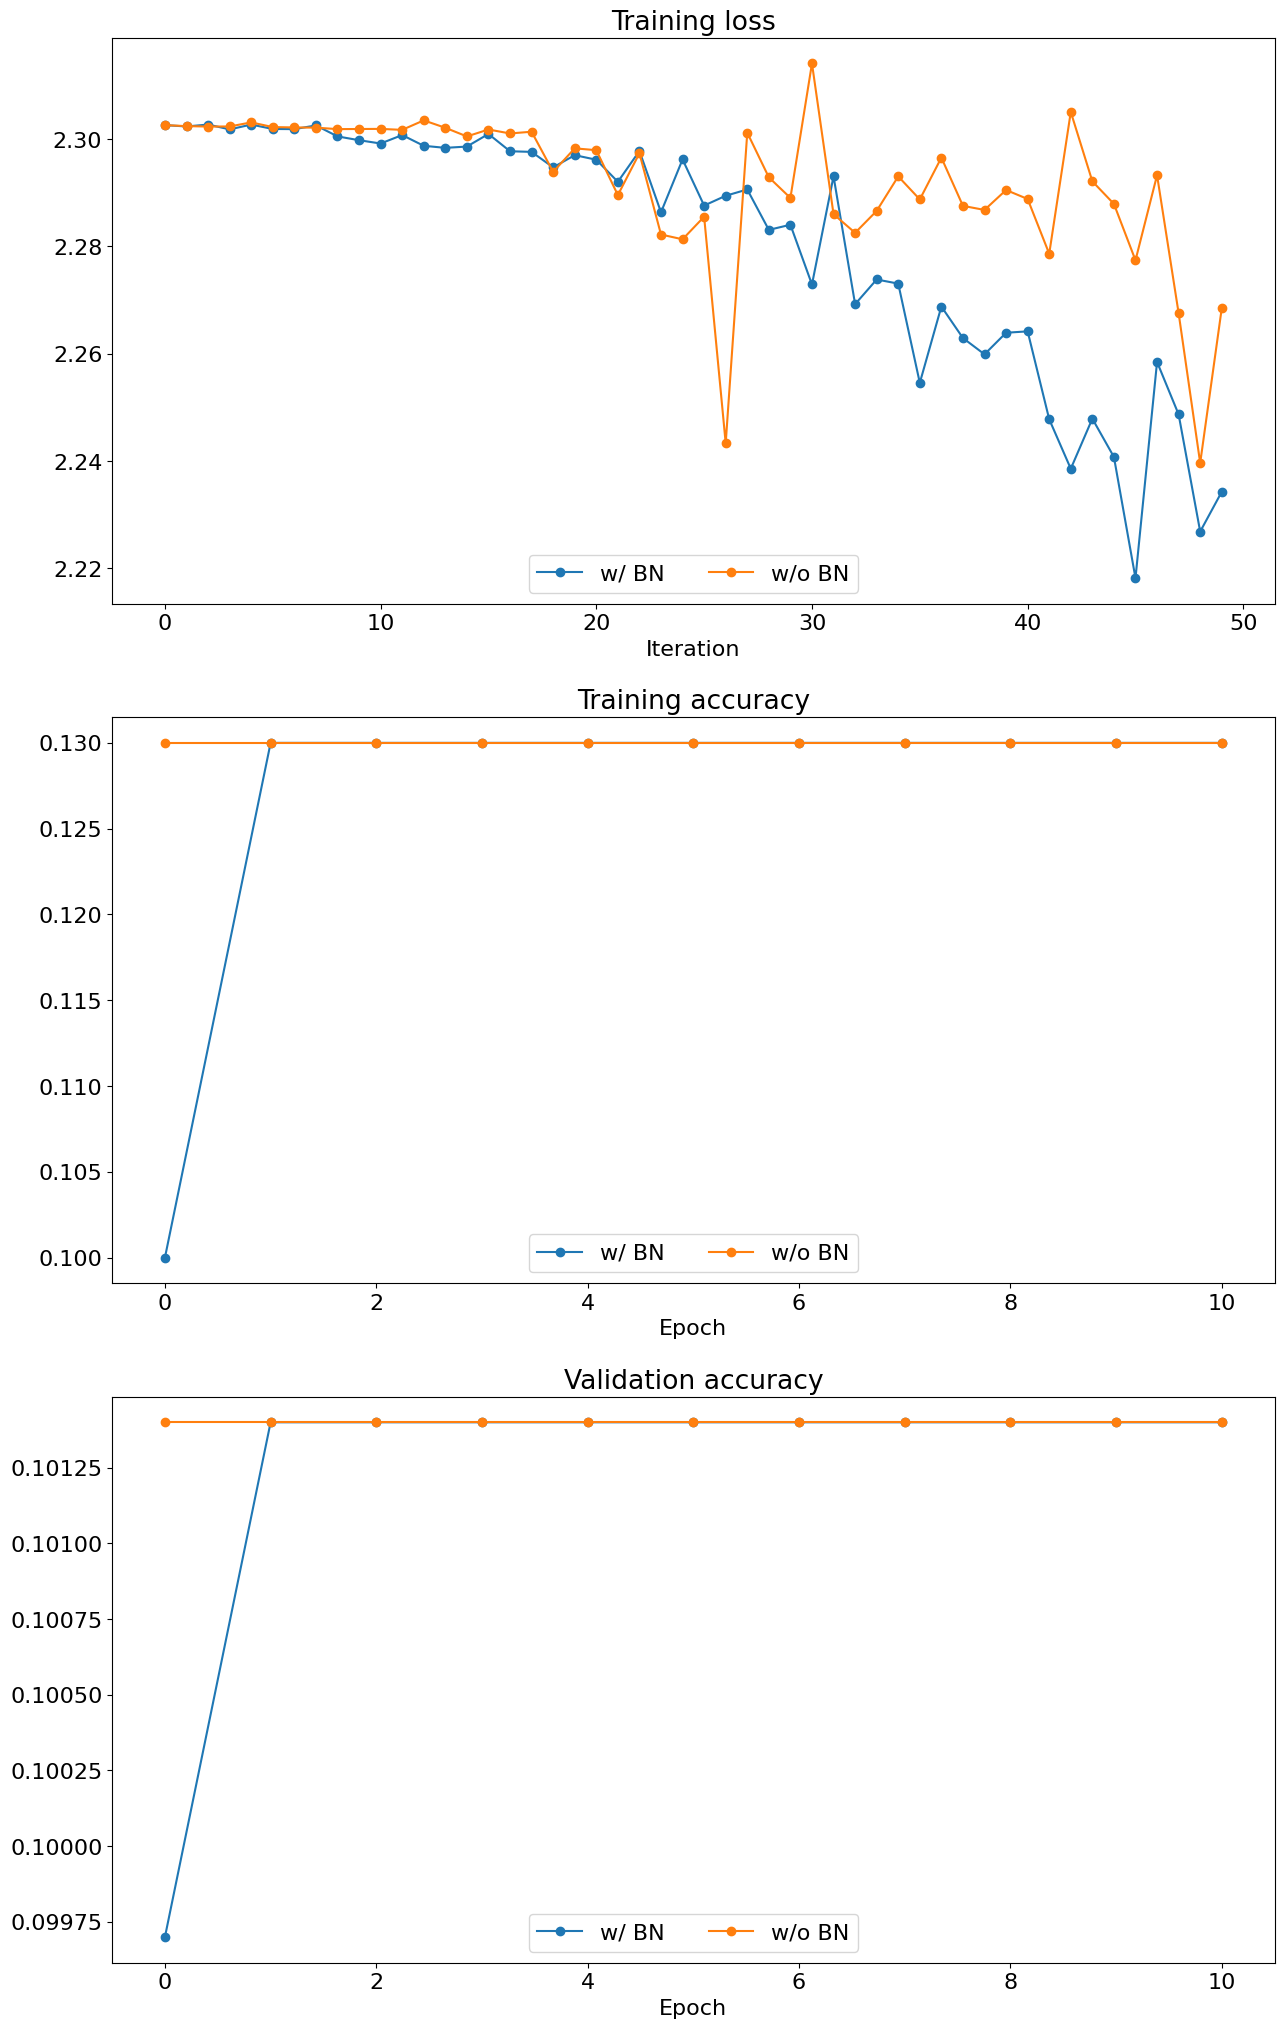

In [32]:
def plot_training_history_bn(title, label, solvers, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
  """utility function for plotting training history"""
  plt.title(title)
  plt.xlabel(label)
  bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
  bl_plots = [plot_fn(solver) for solver in solvers]
  num_bn = len(bn_plots)
  num_bl = len(bl_plots)
  for i in range(num_bn):
    label='w/ BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bn_plots[i], bn_marker, label=label)
  for i in range(num_bl):
    label='w/o BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bl_plots[i], bl_marker, label=label)
  plt.legend(loc='lower center', ncol=num_bn+num_bl)

plt.subplot(3, 1, 1)
plot_training_history_bn('Training loss','Iteration', [solver], [bn_solver], \
                      lambda x: x.loss_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 2)
plot_training_history_bn('Training accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history_bn('Validation accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 25)
plt.show()

## Batch normalization and learning rate

We will now run a small experiment to study the interaction of batch normalization and learning rate.

The first cell will train convolutional networks with different learning rates. The second layer will plot training accuracy and validation set accuracy over time. You should find that using batch normalization helps the network to be less dependent to the learning rate.

In [33]:
from convolutional_networks import DeepConvNet

num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]
num_epochs = 5
lrs = [2e-1, 1e-1, 5e-2]
lrs = [5e-3, 1e-2, 2e-2]

solvers = []
for lr in lrs:
  print('No normalization: learning rate = ', lr)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 1, 2],
                      weight_scale='kaiming',
                      batchnorm=False,
                      reg=1e-5, dtype=torch.float32, device='cuda')
  solver = Solver(model, small_data,
                  num_epochs=num_epochs, batch_size=100,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': lr,
                  },
                  verbose=False, device='cuda')
  solver.train()
  solvers.append(solver)

bn_solvers = []
for lr in lrs:
  print('Normalization: learning rate = ', lr)
  bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                         num_filters=[8, 8, 16, 16, 32, 32],
                         max_pools=[1, 3, 5],
                         weight_scale='kaiming',
                         batchnorm=True,
                         reg=1e-5, dtype=torch.float32, device='cuda')
  bn_solver = Solver(bn_model, small_data,
                     num_epochs=num_epochs, batch_size=128,
                     update_rule=sgd_momentum,
                     optim_config={
                       'learning_rate': lr,
                     },
                     verbose=False, device='cuda')
  bn_solver.train()
  bn_solvers.append(bn_solver)

No normalization: learning rate =  0.005
No normalization: learning rate =  0.01
No normalization: learning rate =  0.02
Normalization: learning rate =  0.005
Normalization: learning rate =  0.01
Normalization: learning rate =  0.02


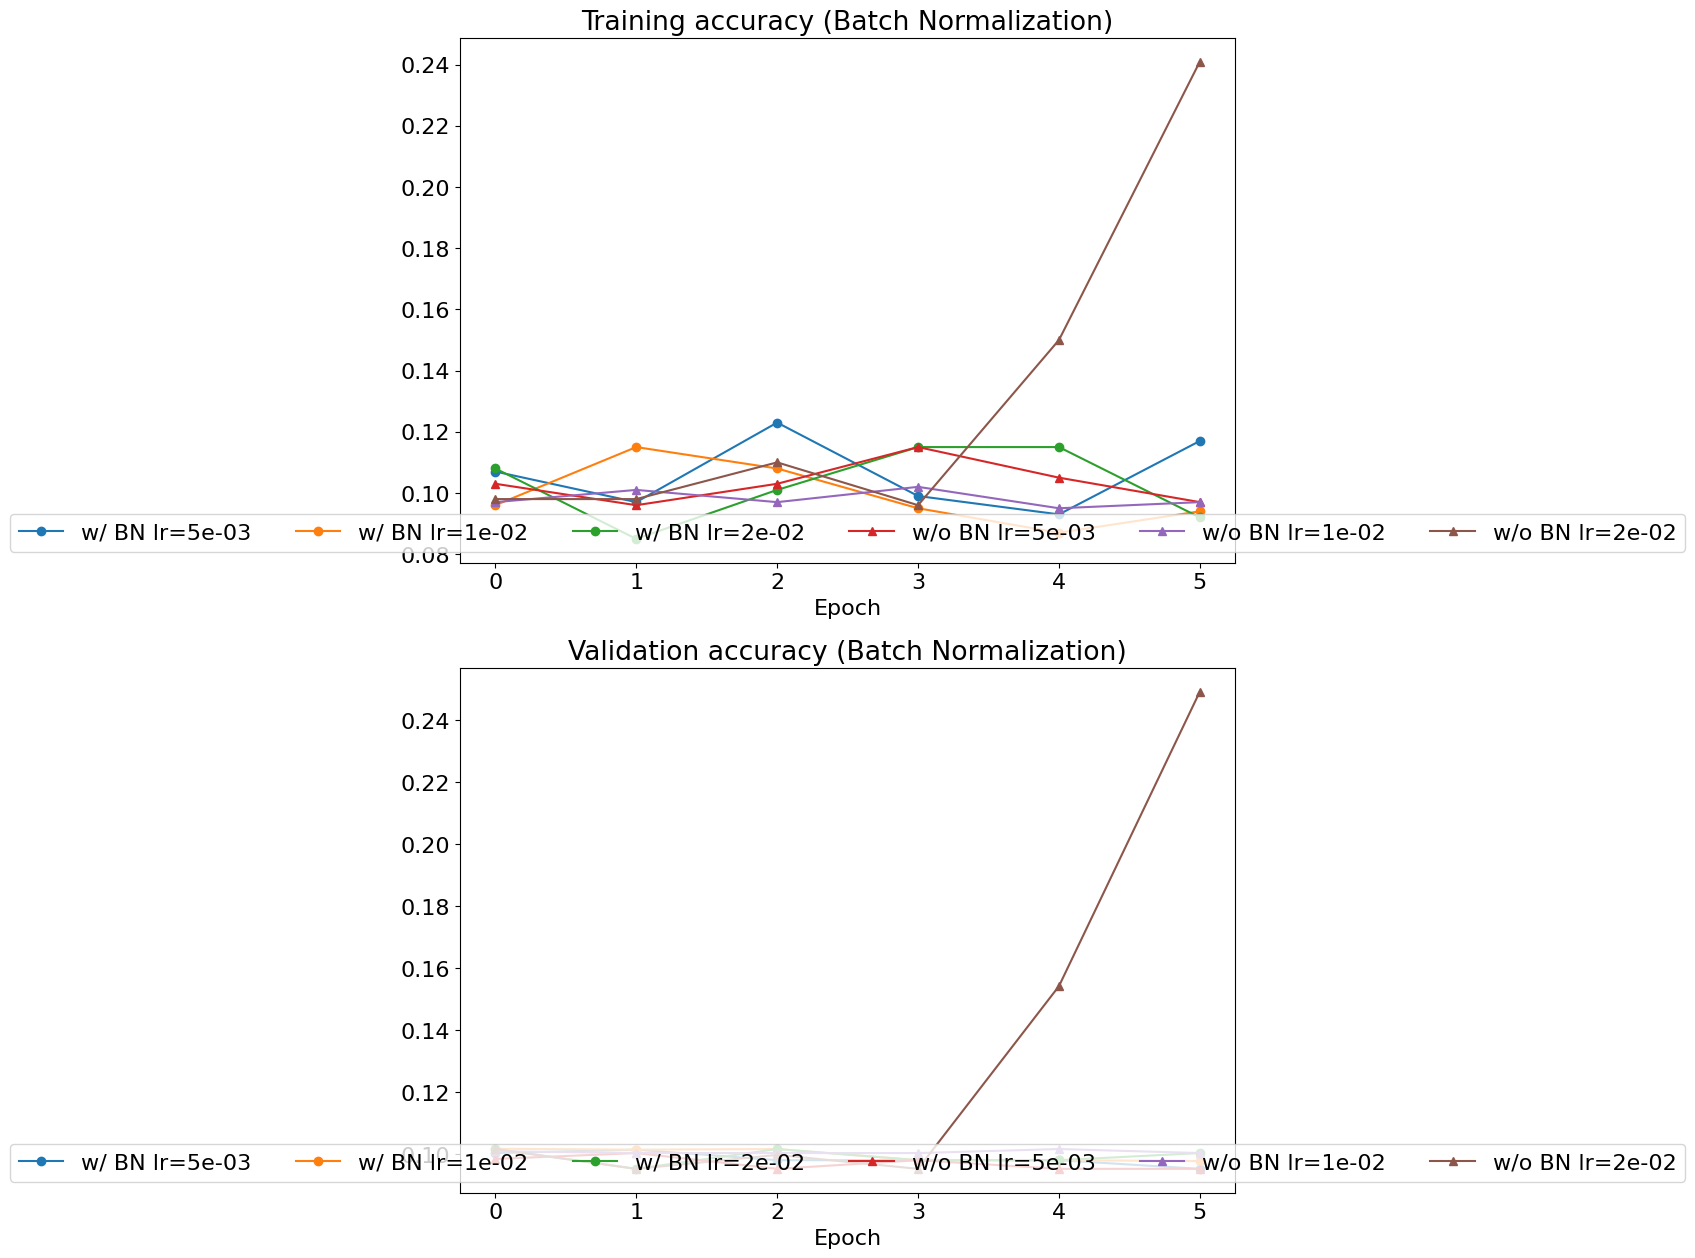

In [34]:
plt.subplot(2, 1, 1)
plot_training_history_bn('Training accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])
plt.subplot(2, 1, 2)
plot_training_history_bn('Validation accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])

plt.gcf().set_size_inches(10, 15)
plt.show()